# Waveform for a Toymodel Cherenkov Shower

Using the reference pulse of a camera, and information about photon arrival times in a waveform, can we generate our our waveforms in an efficient way?

In [98]:
import numpy as np
from scipy.stats import norm
from scipy.ndimage import convolve1d
from matplotlib import pyplot as plt
%matplotlib inline

## Step 1: The Camera

In [163]:
# Define camera properties
sample_width_ns = 0.9
n_samples = 96

In [164]:
# Create reference pulses
ref_x_input, ref_y_input = np.loadtxt("ref_input.txt", unpack=True)
ref_x_simtel, ref_y_simtel = np.load("ref_simtel.npy")

ref_duration = 67
n_ref_samples = 100
pulse_sigma = 6
ref_x_norm = np.linspace(0, ref_duration, n_ref_samples)
ref_y_norm = norm.pdf(ref_x_norm, ref_duration/2, pulse_sigma)

# Replicate simtelarray reference pulse processing
def process_reference_pulse_simtel(ref_x, ref_y):
    ref_width_ns = sample_width_ns/10
    ref_interp_x = np.arange(0, ref_x.max(), ref_width_ns)
    ref_interp_y = np.interp(ref_interp_x, ref_x, ref_y)
    ref_interp_y /= ref_interp_y.max()
    return ref_interp_x, ref_interp_y

ref_x_input, ref_y_input = process_reference_pulse_simtel(ref_x_input, ref_y_input)
ref_x_simtel, ref_y_simtel = process_reference_pulse_simtel(ref_x_simtel, ref_y_simtel)
ref_x_norm, ref_y_norm = process_reference_pulse_simtel(ref_x_norm, ref_y_norm)

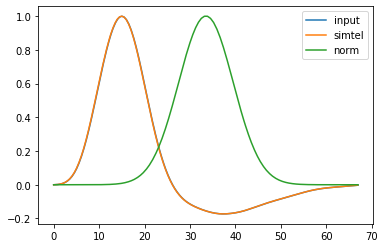

In [165]:
plt.plot(ref_x_input, ref_y_input, label="input")
plt.plot(ref_x_simtel, ref_y_simtel, label="simtel")
plt.plot(ref_x_norm, ref_y_norm, label="norm")
plt.legend(loc='best')

## Step 2: Single Waveform Algorithm

In [166]:
def get_single_waveform(ref_x, ref_y, times):
    ref_sample_width_ns = ref_x[1] - ref_x[0]
    n_upsampled_samples = n_samples * 10
    waveform, edges = np.histogram(
        times, bins=n_upsampled_samples, range=[0, n_samples*sample_width_ns]
    )
    origin = (ref_y.argmax() - ref_y.size // 2)
    ref_y_scaled = ref_y / (ref_y.sum() * ref_sample_width_ns)
    convolved = convolve1d(
        waveform.astype(np.float), ref_y_scaled, 
        mode='constant', origin=origin
    )
    x = edges[:-1]
    return x, waveform, convolved

39.96000000000001


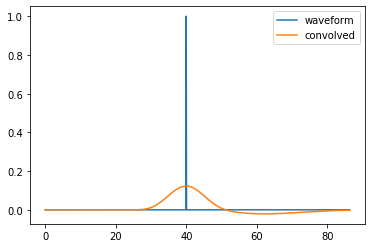

In [167]:
# Test
x, waveform, convolved = get_single_waveform(ref_x_simtel, ref_y_simtel, [40])
plt.plot(x, waveform, label="waveform")
plt.plot(x, convolved, label="convolved")
plt.legend(loc='best')
print(x[waveform.argmax()])

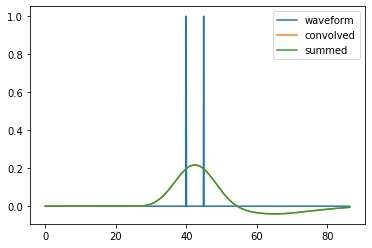

In [169]:
# Test sum
_, _, convolved40 = get_single_waveform(ref_x_simtel, ref_y_simtel, [40])
_, _, convolved45 = get_single_waveform(ref_x_simtel, ref_y_simtel, [45])
x, waveform, convolved = get_single_waveform(ref_x_simtel, ref_y_simtel, [40, 45])
plt.plot(x, waveform, label="waveform")
plt.plot(x, convolved, label="convolved")
plt.plot(x, convolved40+convolved45, label="summed")
plt.legend(loc='best')

In [170]:
# Test charge
times = [40, 40, 45]
true_charge = len(times)
x, waveform, convolved = get_single_waveform(ref_x_simtel, ref_y_simtel, times)
upsample_width_ns = x[1] - x[0]
print(true_charge, convolved.sum() * upsample_width_ns)

3 3.032969331925315


## Step 3: Resampling the Waveform

In [182]:
def get_single_waveform_resampled(ref_x, ref_y, times):
    ref_sample_width_ns = ref_x[1] - ref_x[0]
    n_upsampled_samples = n_samples * 10
    waveform, edges = np.histogram(
        times, bins=n_upsampled_samples, range=[0, n_samples*sample_width_ns]
    )
    origin = (ref_y.argmax() - ref_y.size // 2)
    ref_y_scaled = ref_y / (ref_y.sum() * ref_sample_width_ns)
    convolved = convolve1d(
        waveform.astype(np.float), ref_y_scaled, 
        mode='constant', origin=origin
    )
    resampled = convolved.reshape(convolved.shape[-1]//10, 10).sum(1) / 10
    x = edges[:-1][::10]
    return x, resampled

29.7
(array([0.99629922]), array([37.10580653]))
(array([1.00205074]), array([37.19497205]))
(array([0.99629922]), array([38.21691764]))
(array([0.99800244]), array([38.23477639]))
[29.57378918]
[30.02300038]
[30.47378918]
[30.5642285]


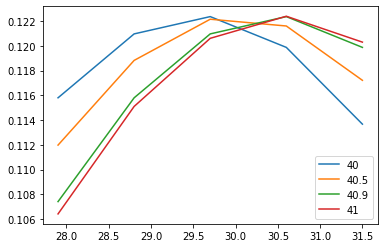

In [214]:
x, waveform_40 = get_single_waveform_resampled(ref_x_simtel, ref_y_simtel, [30])
_, waveform_40p5 = get_single_waveform_resampled(ref_x_simtel, ref_y_simtel, [30.5])
_, waveform_40p9 = get_single_waveform_resampled(ref_x_simtel, ref_y_simtel, [30.9])
_, waveform_41 = get_single_waveform_resampled(ref_x_simtel, ref_y_simtel, [31])

slice_ = np.s_[waveform_40p5.argmax()-2:waveform_40p5.argmax()+3]
plt.plot(x[slice_], waveform_40[slice_], label="40")
plt.plot(x[slice_], waveform_40p5[slice_], label="40.5")
plt.plot(x[slice_], waveform_40p9[slice_], label="40.9")
plt.plot(x[slice_], waveform_41[slice_], label="41")
plt.legend()
print(waveform_40p5.argmax()*sample_width_ns)


from ctapipe.image.extractor import extract_around_peak
print(extract_around_peak(waveform_40[None, :], waveform_40.argmax(), 8, 3, sample_width_ns))
print(extract_around_peak(waveform_40p5[None, :], waveform_40p5.argmax(), 8, 3, sample_width_ns))
print(extract_around_peak(waveform_40p9[None, :], waveform_40p9.argmax(), 8, 3, sample_width_ns))
print(extract_around_peak(waveform_41[None, :], waveform_41.argmax(), 8, 3, sample_width_ns))

from CHECLabPy.waveform_reducers.cross_correlation import extract_pulse_time
print(extract_pulse_time(waveform_40[None, :], waveform_40.argmax()) * sample_width_ns)
print(extract_pulse_time(waveform_40p5[None, :], waveform_40p5.argmax()) * sample_width_ns)
print(extract_pulse_time(waveform_40p9[None, :], waveform_40p9.argmax()) * sample_width_ns)
print(extract_pulse_time(waveform_41[None, :], waveform_41.argmax()) * sample_width_ns)